In [1]:
# import the necessary packages
import cv2
import torch
import pickle
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.models import detection

print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("GPU:", torch.cuda.device_count(), torch.cuda.get_device_name(0)) if torch.cuda.is_available() else print("NO GPU")

Torch: 1.8.2+cu102
Torchvision: 0.9.2+cu102
GPU: 1 Quadro RTX 3000 with Max-Q Design


In [2]:
# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the list of categories in the COCO dataset 
# and then generate a set of bounding box colors for each class
#CLASSES = pickle.loads(open(args["labels"], "rb").read())
CLASSES = pd.read_csv("coco_labels.txt", header=None).values.squeeze().tolist()
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [3]:
# show classes and colors
print("totoal classes:", len(CLASSES))
print(CLASSES[:5])
print(COLORS[:5])

totoal classes: 91
['person', 'bicycle', 'car', 'motorcycle', 'airplane']
[[148.0101923  158.84062949  98.31333593]
 [ 73.06875438 158.928521   210.92633767]
 [160.54763541   4.3144849  166.81903651]
 [219.56527841  30.04087203  76.46993767]
 [ 71.78535495 244.62642027  13.47874704]]


In [4]:
# initialize a dictionary containing model name and its corresponding 
# torchvision function call
MODELS = {
    "frcnn-resnet": detection.fasterrcnn_resnet50_fpn,
    "frcnn-mobilenet": detection.fasterrcnn_mobilenet_v3_large_320_fpn,
    "retinanet": detection.retinanet_resnet50_fpn
}

In [5]:
# load the model and set it to evaluation mode
model = MODELS["frcnn-mobilenet"](pretrained=True, progress=True, num_classes=len(CLASSES), pretrained_backbone=True).to(DEVICE)
#model = MODELS["frcnn-resnet"](pretrained=True, progress=True, num_classes=len(CLASSES), pretrained_backbone=True).to(DEVICE)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to C:\Users\zhanghe/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 

In [24]:
# load the image from disk
image = cv2.imread("images/n03127747_crash_helmet.jpg")
orig = image.copy()
print("input image shape:", image.shape)

# convert the image from BGR to RGB channel ordering and change the
# image from channels last to channels first ordering
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.transpose((2, 0, 1))

# add the batch dimension, scale the raw pixel intensities to the
# range [0, 1], and convert the image to a floating point tensor
image = np.expand_dims(image, axis=0)
image = image / 255.0
image = torch.FloatTensor(image)
print("preprocessed image shape:", image.shape)

# send the input to the device and pass the it through the network to
# get the detections and predictions
image = image.to(DEVICE)
detections = model(image)[0]
detections

input image shape: (353, 500, 3)
preprocessed image shape: torch.Size([1, 3, 353, 500])


{'boxes': tensor([[234.3944,  38.4622, 392.2106, 240.9571],
         [209.0482,  70.5134, 402.9429, 321.4232],
         [247.6620,  37.9977, 371.3939, 158.0039]], device='cuda:0',
        grad_fn=<StackBackward>),
 'labels': tensor([1, 4, 1], device='cuda:0'),
 'scores': tensor([0.9977, 0.9922, 0.1163], device='cuda:0', grad_fn=<IndexBackward>)}

[INFO] person: 99.77%
[INFO] motorcycle: 99.22%


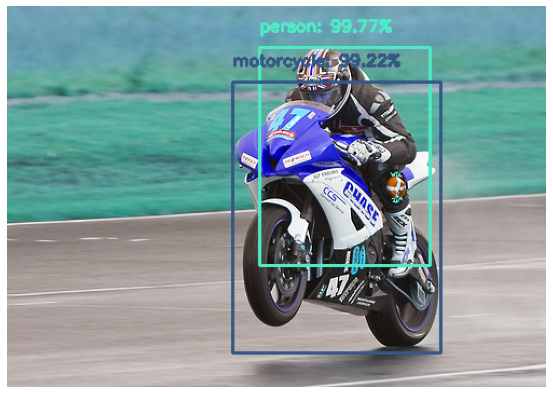

In [25]:
# loop over the detections
for i in range(0, len(detections["boxes"])):
    
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections["scores"][i]
    
    if confidence > 0.45:
        # get class index and bbox
        idx = int(detections["labels"][i]) - 1
        box = detections["boxes"][i].detach().cpu().numpy()
        (startX, startY, endX, endY) = box.astype("int")

        # display the prediction to our terminal
        label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
        print("[INFO] {}".format(label))

        # draw the bounding box and label on the image
        orig = cv2.rectangle(orig, (startX, startY), (endX, endY), COLORS[idx], 2)
        y = startY - 15 if startY - 15 > 15 else startY + 15
        orig = cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

# display the figure
plt.figure(figsize=(10, 7))
plt.imshow(orig)
plt.axis("off")
plt.show()

In [ ]:
# Real time detection
# note: use MobileNet to get the best performance vs speed tradeoff!!!

In [6]:
import time
import imutils
from imutils.video import FPS
from imutils.video import VideoStream

In [7]:
# initialize the video stream, allow the camera sensor to warmup,
# and initialize the FPS counter
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)
fps = FPS().start()

[INFO] starting video stream...


In [8]:
# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    orig = frame.copy()
    
    # convert the frame from BGR to RGB channel ordering and change
    # the frame from channels last to channels first ordering
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame.transpose((2, 0, 1))
    
    # add a batch dimension, scale the raw pixel intensities to the
    # range [0, 1], and convert the frame to a floating point tensor
    frame = np.expand_dims(frame, axis=0)
    frame = frame / 255.0
    frame = torch.FloatTensor(frame)
    
    # send the input to the device and pass the it through the
    # network to get the detections and predictions
    frame = frame.to(DEVICE)
    detections = model(frame)[0]
    
    # loop over the detections
    for i in range(0, len(detections["boxes"])):

        # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections["scores"][i]

        if confidence > 0.45:
            # get class index and bbox
            idx = int(detections["labels"][i]) - 1
            box = detections["boxes"][i].detach().cpu().numpy()
            (startX, startY, endX, endY) = box.astype("int")

            # display the prediction to our terminal
            label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
            #print("[INFO] {}".format(label))

            # draw the bounding box and label on the image
            orig = cv2.rectangle(orig, (startX, startY), (endX, endY), COLORS[idx], 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            orig = cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

    # show the output frame
    cv2.imshow("Frame", orig)
    key = cv2.waitKey(1) & 0xFF
    
    # if the 'q' key was pressed, break from the loop
    if key == ord("q"):
        break
    
    # update the FPS counter
    fps.update()

# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] mouse: 87.53%
[INFO] bed: 53.18%
[INFO] remote: 60.32%
[INFO] remote: 59.24%
[INFO] remote: 55.30%
[INFO] remote: 58.91%
[INFO] remote: 57.24%
[INFO] remote: 61.55%
[INFO] remote: 57.07%
[INFO] remote: 58.27%
[INFO] remote: 55.31%
[INFO] remote: 58.75%
[INFO] remote: 57.41%
[INFO] remote: 55.62%
[INFO] remote: 56.76%
[INFO] remote: 57.98%
[INFO] remote: 58.36%
[INFO] remote: 56.62%
[INFO] cell phone: 47.76%
[INFO] remote: 65.89%
[INFO] cell phone: 54.19%
[INFO] cup: 52.18%
[INFO] cup: 74.97%
[INFO] remote: 70.06%
[INFO] cup: 88.14%
[INFO] cell phone: 55.96%
[INFO] remote: 55.66%
[INFO] cup: 85.39%
[INFO] remote: 60.56%
[INFO] cup: 85.39%
[INFO] cell phone: 56.36%
[INFO] remote: 55.33%
[INFO] cup: 92.45%
[INFO] cell phone: 68.01%
[INFO] cup: 97.03%
[INFO] cell phone: 54.97%
[INFO] remote: 47.77%
[INFO] cup: 96.66%
[INFO] remote: 50.92%
[INFO] cell phone: 47.57%
[INFO] cup: 94.89%
[INFO] remote: 64.29%
[INFO] cup: 98.59%
[INFO] cell phone: 63.26%
[INFO] remote: 58.90%
[INFO] cup: 

[INFO] potted plant: 99.08%
[INFO] tv: 96.29%
[INFO] potted plant: 46.28%
[INFO] potted plant: 99.23%
[INFO] tv: 93.32%
[INFO] potted plant: 97.84%
[INFO] tv: 94.50%
[INFO] potted plant: 98.53%
[INFO] tv: 96.30%
[INFO] tv: 98.86%
[INFO] potted plant: 98.31%
[INFO] potted plant: 98.28%
[INFO] tv: 97.95%
[INFO] potted plant: 97.53%
[INFO] tv: 96.77%
[INFO] tv: 95.85%
[INFO] potted plant: 94.00%
[INFO] microwave: 47.85%
[INFO] oven: 46.11%
[INFO] microwave: 73.81%
[INFO] remote: 54.31%
[INFO] person: 47.97%
[INFO] microwave: 81.18%
[INFO] microwave: 81.28%
[INFO] microwave: 78.32%
[INFO] refrigerator: 85.91%
[INFO] refrigerator: 65.68%
[INFO] refrigerator: 98.32%
[INFO] refrigerator: 79.64%
[INFO] refrigerator: 97.17%
[INFO] refrigerator: 88.90%
[INFO] refrigerator: 77.36%
[INFO] refrigerator: 95.35%
[INFO] refrigerator: 52.03%
[INFO] refrigerator: 77.64%
[INFO] refrigerator: 96.98%
[INFO] refrigerator: 94.29%
[INFO] refrigerator: 94.98%
[INFO] refrigerator: 47.48%
[INFO] refrigerator: 92

[INFO] person: 97.93%
[INFO] bed: 56.43%
[INFO] person: 54.60%
[INFO] person: 95.98%
[INFO] person: 89.00%
[INFO] person: 78.21%
[INFO] couch: 57.57%
[INFO] person: 97.87%
[INFO] person: 96.01%
[INFO] person: 61.08%
[INFO] person: 57.87%
[INFO] person: 99.92%
[INFO] person: 93.51%
[INFO] person: 99.99%
[INFO] person: 74.36%
[INFO] person: 99.99%
[INFO] tv: 73.54%
[INFO] remote: 66.83%
[INFO] person: 64.44%
[INFO] person: 99.99%
[INFO] person: 83.76%
[INFO] person: 99.99%
[INFO] person: 94.02%
[INFO] person: 99.94%
[INFO] person: 88.83%
[INFO] baseball bat: 70.13%
[INFO] person: 99.88%
[INFO] person: 96.06%
[INFO] person: 99.93%
[INFO] person: 82.32%
[INFO] person: 99.82%
[INFO] person: 89.84%
[INFO] person: 99.76%
[INFO] person: 81.68%
[INFO] person: 98.76%
[INFO] person: 59.85%
[INFO] person: 95.00%
[INFO] person: 86.52%
[INFO] couch: 46.61%
[INFO] person: 95.64%
[INFO] person: 93.06%
[INFO] bed: 56.19%
[INFO] person: 94.27%
[INFO] person: 93.06%
[INFO] person: 97.47%
[INFO] person: 9

[INFO] bed: 98.91%
[INFO] person: 96.26%
[INFO] bed: 98.56%
[INFO] person: 97.64%
[INFO] book: 45.10%
[INFO] person: 98.72%
[INFO] bed: 97.79%
[INFO] chair: 56.46%
[INFO] book: 53.58%
[INFO] person: 97.15%
[INFO] bed: 96.91%
[INFO] book: 55.88%
[INFO] person: 98.56%
[INFO] bed: 97.31%
[INFO] book: 60.89%
[INFO] chair: 52.48%
[INFO] person: 98.59%
[INFO] bed: 97.23%
[INFO] book: 47.79%
[INFO] person: 99.05%
[INFO] bed: 97.81%
[INFO] person: 99.06%
[INFO] bed: 95.58%
[INFO] book: 50.18%
[INFO] person: 99.20%
[INFO] bed: 96.55%
[INFO] book: 48.68%
[INFO] person: 98.58%
[INFO] bed: 96.39%
[INFO] person: 99.59%
[INFO] bed: 95.74%
[INFO] book: 50.26%
[INFO] person: 99.64%
[INFO] bed: 94.42%
[INFO] person: 99.62%
[INFO] bed: 97.32%
[INFO] person: 99.65%
[INFO] bed: 95.75%
[INFO] person: 99.79%
[INFO] bed: 93.59%
[INFO] person: 99.70%
[INFO] bed: 95.12%
[INFO] person: 99.89%
[INFO] bed: 93.69%
[INFO] person: 99.37%
[INFO] bed: 96.80%
[INFO] person: 99.48%
[INFO] bed: 96.21%
[INFO] person: 99.3

[INFO] person: 99.83%
[INFO] book: 59.04%
[INFO] book: 58.49%
[INFO] book: 53.89%
[INFO] book: 53.47%
[INFO] book: 50.57%
[INFO] book: 48.69%
[INFO] book: 47.18%
[INFO] book: 45.89%
[INFO] person: 99.70%
[INFO] chair: 62.75%
[INFO] book: 62.68%
[INFO] book: 62.12%
[INFO] book: 61.37%
[INFO] book: 53.00%
[INFO] book: 51.24%
[INFO] book: 50.88%
[INFO] book: 49.41%
[INFO] book: 46.33%
[INFO] person: 99.55%
[INFO] book: 70.92%
[INFO] book: 68.35%
[INFO] chair: 65.86%
[INFO] book: 63.39%
[INFO] book: 62.89%
[INFO] book: 60.26%
[INFO] book: 59.44%
[INFO] book: 53.75%
[INFO] book: 49.02%
[INFO] book: 45.20%
[INFO] person: 99.38%
[INFO] chair: 78.55%
[INFO] book: 73.83%
[INFO] book: 71.75%
[INFO] book: 71.49%
[INFO] book: 70.16%
[INFO] book: 60.34%
[INFO] book: 55.07%
[INFO] book: 54.27%
[INFO] book: 53.95%
[INFO] book: 53.33%
[INFO] bottle: 53.14%
[INFO] person: 99.21%
[INFO] chair: 83.32%
[INFO] bottle: 82.79%
[INFO] book: 72.14%
[INFO] book: 67.28%
[INFO] book: 63.13%
[INFO] book: 61.66%
[I

[INFO] book: 86.23%
[INFO] book: 80.17%
[INFO] book: 73.73%
[INFO] book: 72.22%
[INFO] book: 70.51%
[INFO] cell phone: 69.52%
[INFO] book: 67.91%
[INFO] book: 67.89%
[INFO] book: 55.62%
[INFO] sink: 54.29%
[INFO] book: 47.14%
[INFO] book: 46.29%
[INFO] book: 79.84%
[INFO] book: 74.82%
[INFO] cell phone: 71.84%
[INFO] book: 68.42%
[INFO] book: 68.38%
[INFO] book: 68.28%
[INFO] sink: 66.25%
[INFO] book: 60.58%
[INFO] book: 59.30%
[INFO] book: 55.17%
[INFO] book: 55.17%
[INFO] book: 53.34%
[INFO] book: 48.57%
[INFO] book: 70.96%
[INFO] book: 70.08%
[INFO] book: 67.52%
[INFO] book: 66.63%
[INFO] book: 66.56%
[INFO] book: 65.66%
[INFO] sink: 60.53%
[INFO] book: 58.96%
[INFO] book: 57.32%
[INFO] book: 47.52%
[INFO] book: 47.43%
[INFO] book: 83.00%
[INFO] sink: 78.16%
[INFO] book: 77.82%
[INFO] book: 71.52%
[INFO] book: 69.51%
[INFO] book: 64.09%
[INFO] book: 60.69%
[INFO] book: 58.88%
[INFO] book: 56.49%
[INFO] book: 55.20%
[INFO] book: 52.39%
[INFO] book: 47.83%
[INFO] book: 45.53%
[INFO] s

[INFO] person: 94.91%
[INFO] person: 90.55%
[INFO] person: 85.87%
[INFO] tv: 84.58%
[INFO] person: 89.36%
[INFO] bed: 73.14%
[INFO] person: 72.20%
[INFO] person: 61.22%
[INFO] person: 93.40%
[INFO] person: 87.42%
[INFO] bed: 60.64%
[INFO] remote: 56.44%
[INFO] person: 98.68%
[INFO] person: 96.45%
[INFO] cell phone: 90.71%
[INFO] book: 50.38%
[INFO] person: 97.84%
[INFO] person: 94.11%
[INFO] cell phone: 85.53%
[INFO] person: 95.01%
[INFO] cell phone: 85.81%
[INFO] person: 61.29%
[INFO] person: 89.81%
[INFO] cell phone: 75.75%
[INFO] surfboard: 63.64%
[INFO] person: 61.29%
[INFO] person: 98.22%
[INFO] person: 95.10%
[INFO] cell phone: 84.90%
[INFO] person: 98.90%
[INFO] person: 91.54%
[INFO] cell phone: 85.24%
[INFO] person: 85.63%
[INFO] person: 85.54%
[INFO] cell phone: 56.58%
[INFO] remote: 45.90%
[INFO] cell phone: 93.85%
[INFO] person: 71.42%
[INFO] remote: 66.56%
[INFO] cell phone: 81.83%
[INFO] person: 65.78%
[INFO] remote: 64.14%
[INFO] person: 81.77%
[INFO] cell phone: 76.30%
[

[INFO] person: 99.69%
[INFO] person: 99.38%
[INFO] person: 83.65%
[INFO] dining table: 65.48%
[INFO] person: 98.52%
[INFO] person: 96.22%
[INFO] person: 70.79%
[INFO] dining table: 51.65%
[INFO] person: 99.86%
[INFO] person: 99.61%
[INFO] person: 99.94%
[INFO] person: 99.93%
[INFO] dining table: 47.23%
[INFO] person: 99.93%
[INFO] person: 99.86%
[INFO] dining table: 73.47%
[INFO] person: 99.86%
[INFO] person: 99.76%
[INFO] person: 99.88%
[INFO] person: 99.39%
[INFO] person: 99.70%
[INFO] person: 98.95%
[INFO] person: 99.74%
[INFO] person: 99.72%
[INFO] dining table: 53.22%
[INFO] person: 99.88%
[INFO] person: 99.48%
[INFO] dining table: 75.39%
[INFO] person: 99.67%
[INFO] person: 98.47%
[INFO] bed: 88.79%
[INFO] person: 99.59%
[INFO] person: 89.30%
[INFO] person: 51.12%
[INFO] book: 45.23%
[INFO] person: 99.55%
[INFO] person: 78.18%
[INFO] dining table: 66.26%
[INFO] person: 47.91%
[INFO] person: 99.84%
[INFO] person: 96.87%
[INFO] dining table: 71.83%
[INFO] person: 98.51%
[INFO] pers

[INFO] person: 99.92%
[INFO] bed: 69.81%
[INFO] person: 99.95%
[INFO] bed: 90.32%
[INFO] person: 99.96%
[INFO] bed: 89.67%
[INFO] person: 99.97%
[INFO] person: 99.95%
[INFO] person: 99.96%
[INFO] suitcase: 52.34%
[INFO] person: 99.93%
[INFO] bed: 68.73%
[INFO] book: 53.99%
[INFO] bed: 53.22%
[INFO] person: 99.90%
[INFO] book: 65.13%
[INFO] bed: 55.12%
[INFO] person: 52.26%
[INFO] person: 99.90%
[INFO] person: 66.81%
[INFO] book: 47.91%
[INFO] person: 99.86%
[INFO] person: 80.99%
[INFO] bed: 76.67%
[INFO] book: 45.57%
[INFO] bed: 45.02%
[INFO] person: 99.80%
[INFO] bed: 94.78%
[INFO] person: 86.89%
[INFO] book: 65.83%
[INFO] book: 55.91%
[INFO] book: 55.14%
[INFO] bottle: 45.35%
[INFO] person: 99.93%
[INFO] bed: 97.94%
[INFO] person: 79.59%
[INFO] book: 64.42%
[INFO] book: 59.33%
[INFO] book: 57.57%
[INFO] book: 54.35%
[INFO] person: 99.75%
[INFO] bed: 96.23%
[INFO] person: 89.65%
[INFO] book: 72.52%
[INFO] book: 72.04%
[INFO] book: 69.35%
[INFO] book: 68.60%
[INFO] book: 67.67%
[INFO] 

[INFO] chair: 78.89%
[INFO] chair: 66.23%
[INFO] tv: 55.07%
[INFO] remote: 48.44%
[INFO] tv: 61.23%
[INFO] chair: 78.29%
[INFO] bed: 55.39%
[INFO] chair: 79.48%
[INFO] chair: 80.04%
[INFO] tv: 47.80%
[INFO] chair: 60.58%
[INFO] bottle: 56.10%
[INFO] bottle: 59.76%
[INFO] bottle: 47.94%
[INFO] bottle: 59.59%
[INFO] bottle: 48.06%
[INFO] bottle: 56.76%
[INFO] car: 68.19%
[INFO] cat: 66.26%
[INFO] laptop: 56.92%
[INFO] laptop: 49.44%
[INFO] laptop: 61.65%
[INFO] book: 59.29%
[INFO] laptop: 46.56%
[INFO] laptop: 65.17%
[INFO] book: 51.08%
[INFO] mouse: 92.05%
[INFO] laptop: 46.40%
[INFO] laptop: 92.59%
[INFO] laptop: 90.05%
[INFO] couch: 81.74%
[INFO] laptop: 86.85%
[INFO] couch: 72.79%
[INFO] laptop: 61.95%
[INFO] chair: 61.94%
[INFO] mouse: 54.46%
[INFO] book: 48.14%
[INFO] chair: 97.75%
[INFO] laptop: 67.33%
[INFO] laptop: 56.70%
[INFO] dining table: 53.84%
[INFO] chair: 96.47%
[INFO] laptop: 89.82%
[INFO] chair: 98.77%
[INFO] laptop: 91.50%
[INFO] chair: 72.92%
[INFO] laptop: 98.21%
[I

[INFO] bed: 92.68%
[INFO] mouse: 88.61%
[INFO] bed: 93.40%
[INFO] mouse: 85.30%
[INFO] bed: 92.54%
[INFO] mouse: 87.07%
[INFO] bed: 92.52%
[INFO] mouse: 85.71%
[INFO] bed: 93.22%
[INFO] mouse: 86.68%
[INFO] bed: 92.05%
[INFO] mouse: 89.68%
[INFO] bed: 92.47%
[INFO] mouse: 87.59%
[INFO] bed: 92.26%
[INFO] mouse: 89.29%
[INFO] bed: 92.64%
[INFO] mouse: 89.66%
[INFO] elapsed time: 171.26
[INFO] approx. FPS: 9.14
